In [1]:
import sys
import sklearn
import numpy as np
import os
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
x, y = mnist["data"], mnist["target"]
x.shape

(70000, 784)

In [4]:
y.shape

(70000,)

(-0.5, 27.5, 27.5, -0.5)

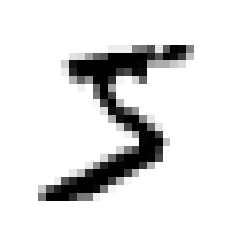

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt

someDigit = x[0]
someDigitImage = someDigit.reshape(28, 28)
plt.imshow(someDigitImage, cmap=mpl.cm.binary)
plt.axis("off")

In [6]:
y[0]

'5'

In [7]:
y = y.astype(np.uint8)

In [8]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [9]:
def plot_digits(instances, imagesPer_row=10, **options):
    size = 28
    imagesPer_row = min(len(instances), imagesPer_row)
    images = [instance.reshape(size,size) for instance in instances]
    nRows = (len(instances) - 1) // imagesPer_row + 1
    row_images = []
    nEmpty = nRows * imagesPer_row - len(instances)
    images.append(np.zeros((size, size * nEmpty)))
    for row in range(nRows):
        rimages = images[row * imagesPer_row : (row + 1) * imagesPer_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

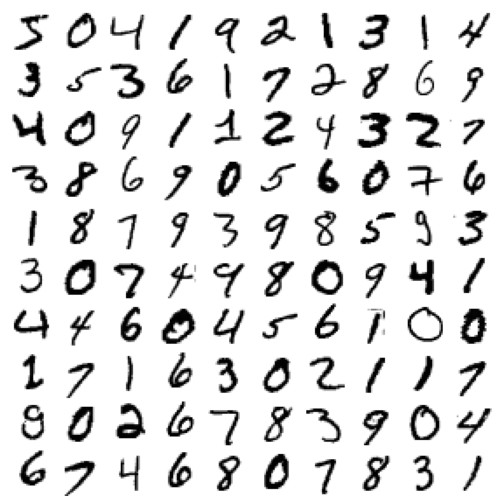

In [10]:
plt.figure(figsize=(9,9))
example_images = x[:100]
plot_digits(example_images, imagesPer_row=10)

In [11]:
y[0]

5

In [12]:
xTrain, xTest, yTrain, yTest = x[:6000], x[6000:], y[:6000], y[6000:]

Binary Classifier

In [13]:
yTrain5 = (yTrain == 5)
yTest5 = (yTest == 5)

In [14]:
from sklearn.linear_model import SGDClassifier

sgdClf = SGDClassifier(max_iter=100, tol=1e-3, random_state=42)
sgdClf.fit(xTrain, yTrain5)

SGDClassifier(max_iter=100, random_state=42)

In [15]:
sgdClf.predict([someDigit])

array([ True])

In [16]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgdClf, xTrain, yTrain5, cv=2, scoring="accuracy")

array([0.961     , 0.96066667])

In [17]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(xTrain, yTrain5):
    cloneClf = clone(sgdClf)
    xTrainFolds = xTrain[train_index]
    yTrainFolds = yTrain5[train_index]
    xTestFold = xTrain[test_index]
    yTestFold = yTrain5[test_index]

    cloneClf.fit(xTrainFolds, yTrainFolds)
    yPred = cloneClf.predict(xTestFold)
    nCorrect = sum(yPred == yTestFold)
    print(nCorrect / len(yPred))

C:\Users\Austin\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


0.962
0.956
0.9665


In [18]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [19]:
never5Clf = Never5Classifier()
cross_val_score(never5Clf, xTrain, yTrain5, cv=2, scoring="accuracy")

array([0.90866667, 0.92      ])

In [20]:
from sklearn.model_selection import cross_val_predict

yTrainPred = cross_val_predict(sgdClf, xTrain, yTrain5, cv=2)

In [21]:
from sklearn.metrics import confusion_matrix

confusion_matrix(yTrain5, yTrainPred)

array([[5406,   80],
       [ 155,  359]], dtype=int64)

In [22]:
yTrainPerfectPredictions = yTrain5  # pretend we reached perfection
confusion_matrix(yTrain5, yTrainPerfectPredictions)

array([[5486,    0],
       [   0,  514]], dtype=int64)

In [23]:
from sklearn.metrics import precision_score, recall_score

precision_score(yTrain5, yTrainPred)

0.8177676537585421

In [24]:
recall_score(yTrain5, yTrainPred)

0.6984435797665369

In [25]:
from sklearn.metrics import f1_score
f1_score(yTrain5, yTrainPred)

0.7534102833158447

In [26]:
yScores = sgdClf.decision_function([someDigit])
yScores

array([38042.34312442])

In [27]:
threshold = 0
ySomeDigitPred = (yScores > threshold)

In [28]:
ySomeDigitPred

array([ True])

In [29]:
threshold = 8000
ySomeDigitPred = (yScores > threshold)
ySomeDigitPred

array([ True])

In [30]:
yScores = cross_val_predict(sgdClf, xTrain, yTrain5, cv=2,
                             method="decision_function")

In [31]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(yTrain5, yScores)

In [32]:
def plotPrecision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.show()

In [33]:
##(yTrainPred == (yScores > 0)).all()

In [34]:
def plotPrecision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

In [38]:
threshold90Precision = thresholds[np.argmax(precisions >= 0.90)]

In [39]:
threshold90Precision

106262.31428172714

In [40]:
yTrainPred90 = (yScores >= threshold90Precision)

In [41]:
precision_score(yTrain5, yTrainPred90)

0.9017857142857143

In [42]:
recall_score(yTrain5, yTrainPred90)

0.5894941634241245

ROC Curves

In [43]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(yTrain5, yScores)

In [44]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    
plt.show()

In [45]:
from sklearn.metrics import roc_auc_score
roc_auc_score(yTrain5, yScores)

0.9477754482226424

In [46]:
from sklearn.ensemble import RandomForestClassifier
forestClf = RandomForestClassifier(n_estimators=100, random_state=42)
yProbasForest = cross_val_predict(forestClf, xTrain, yTrain5, cv=2,
                                    method="predict_proba")

In [47]:
yScoresForest = yProbasForest[:, 1]
fprForest, tprForest, thresholdsForest = roc_curve(yTrain5,yScoresForest)

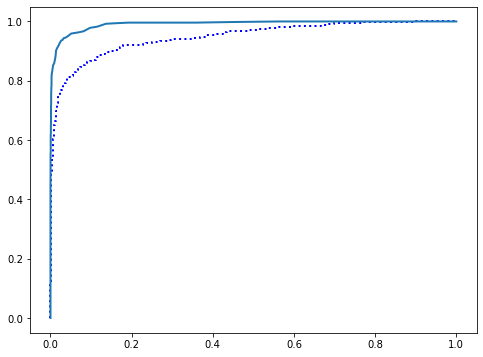

In [48]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fprForest, tprForest, "Random Forest")

In [49]:
roc_auc_score(yTrain5, yScoresForest)

0.9917311628751502

In [50]:
yTrainPredForest = cross_val_predict(forestClf, xTrain, yTrain5, cv=2)
precision_score(yTrain5, yTrainPredForest)

0.9850746268656716

In [51]:
recall_score(yTrain5, yTrainPredForest)

0.642023346303502

Multiclass classification

In [52]:
from sklearn.svm import SVC
svmClf = SVC(random_state=42)
svmClf.fit(xTrain, yTrain)
svmClf.predict([someDigit])

array([5], dtype=uint8)

In [53]:
someDigit_scores = svmClf.decision_function([someDigit])
someDigit_scores

array([[ 1.74201669,  3.75934047,  6.18134457,  8.29644372, -0.30252035,
         9.30527336,  1.74930094,  2.77838477,  7.19221016,  3.87315474]])

In [54]:
np.argmax(someDigit_scores)

5

In [55]:
svmClf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [56]:
svmClf.classes_[5]

5

In [57]:
from sklearn.multiclass import OneVsRestClassifier
ovrClf = OneVsRestClassifier(SVC(random_state=42))
ovrClf.fit(xTrain, yTrain)
ovrClf.predict([someDigit])

array([5], dtype=uint8)

In [58]:
len(ovrClf.estimators_)

10

In [59]:
sgdClf.fit(xTrain, yTrain)
sgdClf.predict([someDigit])

C:\Users\Austin\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


array([5], dtype=uint8)

In [60]:
sgdClf.decision_function([someDigit])

array([[-735711.69660953, -857058.38635209, -281086.00104909,
           8289.73273042, -616793.26669143,   29040.2961313 ,
        -492305.02284074, -834395.17091855, -357292.12286872,
        -303140.2808136 ]])

In [61]:
cross_val_score(sgdClf, xTrain, yTrain, cv=2, scoring="accuracy")

array([0.84333333, 0.86666667])

In [62]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
xTrain_scaled = scaler.fit_transform(xTrain.astype(np.float64))
cross_val_score(sgdClf, xTrain_scaled, yTrain, cv=2, scoring="accuracy")

C:\Users\Austin\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\Austin\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


array([0.86866667, 0.89266667])

In [63]:
yTrainPred = cross_val_predict(sgdClf, xTrain_scaled, yTrain, cv=2)
conf_mx = confusion_matrix(yTrain, yTrainPred)
conf_mx

C:\Users\Austin\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\Austin\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


array([[559,   0,   6,   2,   2,  18,   3,   0,   2,   0],
       [  0, 633,   7,   2,   1,   5,   1,   1,  19,   2],
       [  7,  10, 489,  13,  13,   5,   8,  13,  21,   2],
       [  2,   6,  21, 509,   1,  30,   2,  11,  17,   9],
       [  5,   2,   8,   0, 563,   1,   7,   5,   5,  27],
       [  5,   5,   4,  23,  13, 424,  11,   0,  18,  11],
       [  6,   5,  10,   0,  11,  10, 557,   2,   7,   0],
       [  4,   4,   6,   2,   9,   0,   1, 587,   2,  36],
       [  3,  21,  20,  14,   0,  15,  10,   4, 447,  17],
       [  7,   5,   6,   9,  18,   4,   0,  32,   4, 516]], dtype=int64)

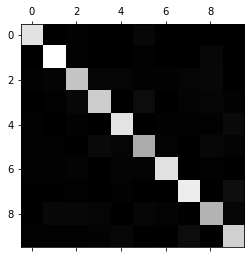

In [64]:
plt.matshow(conf_mx, cmap=plt.cm.gray)

In [65]:
row_sums = conf_mx.sum(axis = 1, keepdims = True)

In [66]:
norm_conf_mx = conf_mx / row_sums

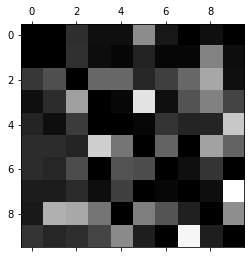

In [67]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)

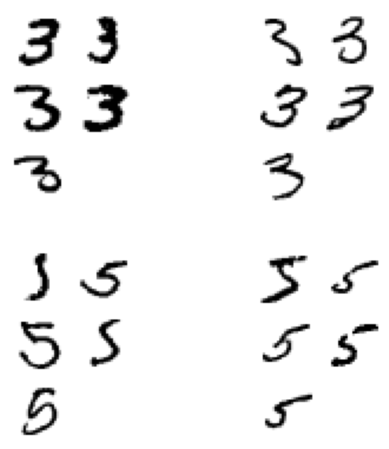

In [68]:
cl_a, cl_b = 3, 5
xaa = xTrain[(yTrain == cl_a) & (yTrainPred == cl_a)]
xab = xTrain[(yTrain == cl_a) & (yTrainPred == cl_b)]
xba = xTrain[(yTrain == cl_b) & (yTrainPred == cl_a)]
xbb = xTrain[(yTrain == cl_b) & (yTrainPred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(xaa[:5], imagesPer_row=2)
plt.subplot(222); plot_digits(xab[:5], imagesPer_row=2)
plt.subplot(223); plot_digits(xba[:5], imagesPer_row=2)
plt.subplot(224); plot_digits(xbb[:5], imagesPer_row=2)

Multilabel classification

In [69]:
from sklearn.neighbors import KNeighborsClassifier

yTrain_large = (yTrain >= 7)
yTrain_odd = (yTrain % 2 == 1)
y_multilabel = np.c_[yTrain_large, yTrain_odd]

knnClf = KNeighborsClassifier()
knnClf.fit(xTrain, y_multilabel)

KNeighborsClassifier()

In [70]:
knnClf.predict([someDigit])

array([[False,  True]])

In [71]:
yTrain_knnPred = cross_val_predict(knnClf, xTrain, y_multilabel, cv=2)
f1_score(y_multilabel, yTrain_knnPred, average="macro")

0.9452081912476975

Multioutput classification

In [72]:
noise = np.random.randint(0, 100, (len(xTrain), 784))
xTrainMod = xTrain + noise
noise = np.random.randint(0, 100, (len(xTest), 784))
xTestMod = xTest + noise
yTrainMod = xTrain
yTestMod = xTest

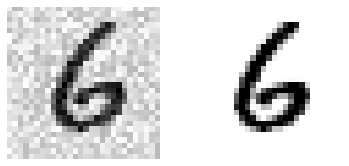

In [73]:
someIndex = 0
plt.subplot(121); plot_digit(xTestMod[someIndex])
plt.subplot(122); plot_digit(yTestMod[someIndex])
plt.show()

In [84]:
knnClf.fit(xTrainMod, yTrainMod)
cleanDigit = knnClf.predict([xTestMod[someIndex]])


### Question 1

In [85]:
from sklearn.model_selection import GridSearchCV

paramGrid = [{'weights': ["uniform", "distance"], 'n_neighbors': [3, 4, 5]}]

knnClf = KNeighborsClassifier()
grid_search = GridSearchCV(knnClf, paramGrid, cv=5, verbose=3)
grid_search.fit(xTrain, yTrain)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] n_neighbors=3, weights=uniform ..................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ...... n_neighbors=3, weights=uniform, score=0.924, total=   8.1s
[CV] n_neighbors=3, weights=uniform ..................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.0s remaining:    0.0s


[CV] ...... n_neighbors=3, weights=uniform, score=0.936, total=   8.0s
[CV] n_neighbors=3, weights=uniform ..................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   16.0s remaining:    0.0s


[CV] ...... n_neighbors=3, weights=uniform, score=0.937, total=   8.0s
[CV] n_neighbors=3, weights=uniform ..................................
[CV] ...... n_neighbors=3, weights=uniform, score=0.939, total=   8.0s
[CV] n_neighbors=3, weights=uniform ..................................
[CV] ...... n_neighbors=3, weights=uniform, score=0.934, total=   8.0s
[CV] n_neighbors=3, weights=distance .................................
[CV] ..... n_neighbors=3, weights=distance, score=0.926, total=   8.0s
[CV] n_neighbors=3, weights=distance .................................
[CV] ..... n_neighbors=3, weights=distance, score=0.934, total=   7.9s
[CV] n_neighbors=3, weights=distance .................................
[CV] ..... n_neighbors=3, weights=distance, score=0.940, total=   8.0s
[CV] n_neighbors=3, weights=distance .................................
[CV] ..... n_neighbors=3, weights=distance, score=0.939, total=   7.9s
[CV] n_neighbors=3, weights=distance .................................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  4.0min finished


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': [3, 4, 5],
                          'weights': ['uniform', 'distance']}],
             verbose=3)

In [86]:
grid_search.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [87]:
grid_search.best_score_

0.9390000000000001

In [88]:
from sklearn.metrics import accuracy_score

yPred = grid_search.predict(xTest)
accuracy_score(yTest, yPred)

0.93875

### Question 2


In [89]:
from scipy.ndimage.interpolation import shift

In [90]:
def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image.reshape([-1])

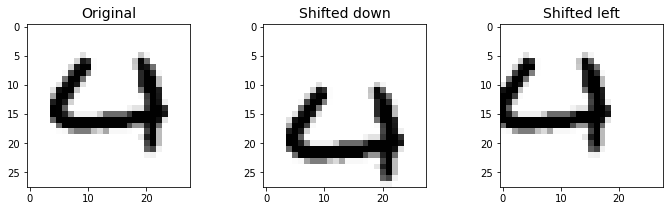

In [91]:
image = xTrain[60]
shifted_image_down = shift_image(image, 0, 5)
shifted_image_left = shift_image(image, -5, 0)

plt.figure(figsize=(12,3))
plt.subplot(131)
plt.title("Original", fontsize=14)
plt.imshow(image.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(132)
plt.title("Shifted down", fontsize=14)
plt.imshow(shifted_image_down.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(133)
plt.title("Shifted left", fontsize=14)
plt.imshow(shifted_image_left.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.show()

In [92]:
xTrain_augmented = [image for image in xTrain]
yTrain_augmented = [label for label in yTrain]

for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    for image, label in zip(xTrain, yTrain):
        xTrain_augmented.append(shift_image(image, dx, dy))
        yTrain_augmented.append(label)

xTrain_augmented = np.array(xTrain_augmented)
yTrain_augmented = np.array(yTrain_augmented)

In [93]:
shuffle_idx = np.random.permutation(len(xTrain_augmented))
xTrain_augmented = xTrain_augmented[shuffle_idx]
yTrain_augmented = yTrain_augmented[shuffle_idx]

In [94]:
knnClf = KNeighborsClassifier(**grid_search.best_params_)

In [95]:
knnClf.fit(xTrain_augmented, yTrain_augmented)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [ ]:
yPred = knnClf.predict(xTest)
accuracy_score(yTest, yPred)

### Question 3

##### this can help with the group proj

In [ ]:
TITANICPATH = os.path.join("datasets", "titanic")

In [ ]:
import pandas as pd

def load_titanic_data(filename, titanicPath=TITANICPATH):
    csvPath = os.path.join(titanicPath, filename)
    return pd.read_csv(csvPath)

In [ ]:
trainData = load_titanic_data("train.csv")
testData = load_titanic_data("test.csv")

In [ ]:
trainData.head()

In [ ]:
trainData.info()

In [ ]:
trainData.describe()

In [ ]:
trainData["Survived"].value_counts()

In [ ]:
trainData["Pclass"].value_counts()

In [ ]:
trainData["Sex"].value_counts()

In [ ]:
trainData["Embarked"].value_counts()

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

numPipeline = Pipeline([
        ("select_numeric", DataFrameSelector(["Age", "SibSp", "Parch", "Fare"])),
        ("imputer", SimpleImputer(strategy="median")),
    ])

In [ ]:
numPipeline.fit_transform(trainData)

In [ ]:
class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X],
                                        index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)

In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
catPipeline = Pipeline([
        ("select_cat", DataFrameSelector(["Pclass", "Sex", "Embarked"])),
        ("imputer", MostFrequentImputer()),
        ("cat_encoder", OneHotEncoder(sparse=False)),
    ])

In [ ]:
catPipeline.fit_transform(trainData)

In [ ]:
from sklearn.pipeline import FeatureUnion
preprocessPipeline = FeatureUnion(transformer_list=[
        ("numPipeline", numPipeline),
        ("catPipeline", catPipeline),
    ])

In [ ]:
xTrain = preprocessPipeline.fit_transform(trainData)
xTrain

In [ ]:
yTrain = trainData["Survived"]

In [ ]:
from sklearn.svm import SVC

svmClf = SVC(gamma="auto")
svmClf.fit(xTrain, yTrain)

In [ ]:
xTest = preprocessPipeline.transform(test_data)
yPred = svmClf.predict(xTest)

In [ ]:
from sklearn.model_selection import cross_val_score

svm_scores = cross_val_score(svmClf, xTrain, yTrain, cv=20)
svm_scores.mean()

In [ ]:
from sklearn.ensemble import RandomForestClassifier

forestClf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_scores = cross_val_score(forestClf, xTrain, yTrain, cv=20)
forest_scores.mean()

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot([1]*10, svm_scores, ".")
plt.plot([2]*10, forest_scores, ".")
plt.boxplot([svm_scores, forest_scores], labels=("SVM","Random Forest"))
plt.ylabel("Accuracy", fontsize=14)
plt.show()

In [ ]:
trainData["AgeBucket"] = trainData["Age"] // 15 * 15
trainData[["AgeBucket", "Survived"]].groupby(['AgeBucket']).mean()

In [ ]:
trainData["RelativesOnboard"] = trainData["SibSp"] + trainData["Parch"]
trainData[["RelativesOnboard", "Survived"]].groupby(['RelativesOnboard']).mean()

### Question 4

In [ ]:
import os
import tarfile
import urllib

DOWNLOAD_ROOT = "http://spamassassin.apache.org/old/publiccorpus/"
HAM_URL = DOWNLOAD_ROOT + "20030228_easy_ham.tar.bz2"
SPAM_URL = DOWNLOAD_ROOT + "20030228_spam.tar.bz2"
SPAMPATH = os.path.join("datasets", "spam")

def fetch_spam_data(spam_url=SPAM_URL, spamPath=SPAMPATH):
    if not os.path.isdir(spamPath):
        os.makedirs(spamPath)
    for filename, url in (("ham.tar.bz2", HAM_URL), ("spam.tar.bz2", SPAM_URL)):
        path = os.path.join(spamPath, filename)
        if not os.path.isfile(path):
            urllib.request.urlretrieve(url, path)
        tar_bz2_file = tarfile.open(path)
        tar_bz2_file.extractall(path=SPAMPATH)
        tar_bz2_file.close()

In [ ]:
fetch_spam_data()

In [ ]:
HAM_DIR = os.path.join(SPAMPATH, "easy_ham")
SPAM_DIR = os.path.join(SPAMPATH, "spam")
ham_filenames = [name for name in sorted(os.listdir(HAM_DIR)) if len(name) > 20]
spam_filenames = [name for name in sorted(os.listdir(SPAM_DIR)) if len(name) > 20]

In [ ]:
len(ham_filenames)

In [ ]:
len(spam_filenames)

In [ ]:
import email
import email.policy

def load_email(is_spam, filename, spamPath=SPAMPATH):
    directory = "spam" if is_spam else "easy_ham"
    with open(os.path.join(spamPath, directory, filename), "rb") as f:
        return email.parser.BytesParser(policy=email.policy.default).parse(f)

In [ ]:
ham_emails = [load_email(is_spam=False, filename=name) for name in ham_filenames]
spam_emails = [load_email(is_spam=True, filename=name) for name in spam_filenames]

In [ ]:
print(ham_emails[1].get_content().strip())

In [ ]:
print(spam_emails[6].get_content().strip())

In [ ]:
def get_email_structure(email):
    if isinstance(email, str):
        return email
    payload = email.get_payload()
    if isinstance(payload, list):
        return "multipart({})".format(", ".join([
            get_email_structure(sub_email)
            for sub_email in payload
        ]))
    else:
        return email.get_content_type()

In [ ]:
from collections import Counter

def structures_counter(emails):
    structures = Counter()
    for email in emails:
        structure = get_email_structure(email)
        structures[structure] += 1
    return structures

In [ ]:
structures_counter(ham_emails).most_common()

In [ ]:
structures_counter(spam_emails).most_common()

In [ ]:
for header, value in spam_emails[0].items():
    print(header,":",value)

In [ ]:
spam_emails[0]["Subject"]

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

X = np.array(ham_emails + spam_emails)
y = np.array([0] * len(ham_emails) + [1] * len(spam_emails))

xTrain, xTest, yTrain, yTest = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
import re
from html import unescape

def html_toPlain_text(html):
    text = re.sub('<head.*?>.*?</head>', '', html, flags=re.M | re.S | re.I)
    text = re.sub('<a\s.*?>', ' HYPERLINK ', text, flags=re.M | re.S | re.I)
    text = re.sub('<.*?>', '', text, flags=re.M | re.S)
    text = re.sub(r'(\s*\n)+', '\n', text, flags=re.M | re.S)
    return unescape(text)

In [ ]:
html_spam_emails = [email for email in xTrain[yTrain==1]
                    if get_email_structure(email) == "text/html"]
sample_html_spam = html_spam_emails[7]
print(sample_html_spam.get_content().strip()[:100], "...")

In [ ]:
print(html_toPlain_text(sample_html_spam.get_content())[:100], "...")

In [ ]:
def email_to_text(email):
    html = None
    for part in email.walk():
        ctype = part.get_content_type()
        if not ctype in ("text/plain", "text/html"):
            continue
        try:
            content = part.get_content()
        except: # in case of encoding issues
            content = str(part.get_payload())
        if ctype == "text/plain":
            return content
        else:
            html = content
    if html:
        return html_toPlain_text(html)

In [ ]:
print(email_to_text(sample_html_spam)[:100], "...")

In [ ]:
try:
    import nltk

    stemmer = nltk.PorterStemmer()
    for word in ("Computations", "Computation", "Computing", "Computed", "Compute", "Compulsive"):
        print(word, "=>", stemmer.stem(word))
except ImportError:
    print("Error: stemming requires the NLTK module.")
    stemmer = None

In [ ]:
# if running this notebook on Colab, we just pip install urlextract
try:
    import google.colab
    !pip install -q -U urlextract
except ImportError:
    pass # not running on Colab

In [ ]:
try:
    import urlextract # may require an Internet connection to download root domain names
    
    url_extractor = urlextract.URLExtract()
    print(url_extractor.find_urls("Will it detect github.com and https://youtu.be/7Pq-S557XQU?t=3m32s"))
except ImportError:
    print("Error: replacing URLs requires the urlextract module.")
    url_extractor = None

In [75]:
from sklearn.base import BaseEstimator, TransformerMixin

class EmailToWordCounterTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, strip_headers=True, lower_case=True, removePunctuation=True,
                 replace_urls=True, replace_numbers=True, stemming=True):
        self.strip_headers = strip_headers
        self.lower_case = lower_case
        self.removePunctuation = removePunctuation
        self.replace_urls = replace_urls
        self.replace_numbers = replace_numbers
        self.stemming = stemming
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        xTransformed = []
        for email in X:
            text = email_to_text(email) or ""
            if self.lower_case:
                text = text.lower()
            if self.replace_urls and url_extractor is not None:
                urls = list(set(url_extractor.find_urls(text)))
                urls.sort(key=lambda url: len(url), reverse=True)
                for url in urls:
                    text = text.replace(url, " URL ")
            if self.replace_numbers:
                text = re.sub(r'\d+(?:\.\d*(?:[eE]\d+))?', 'NUMBER', text)
            if self.removePunctuation:
                text = re.sub(r'\W+', ' ', text, flags=re.M)
            word_counts = Counter(text.split())
            if self.stemming and stemmer is not None:
                stemmed_word_counts = Counter()
                for word, count in word_counts.items():
                    stemmed_word = stemmer.stem(word)
                    stemmed_word_counts[stemmed_word] += count
                word_counts = stemmed_word_counts
            xTransformed.append(word_counts)
        return np.array(xTransformed)

In [76]:
xFew = xTrain[:3]
xFewWordcounts = EmailToWordCounterTransformer().fit_transform(xFew)
xFewWordcounts

NameError: name 'email_to_text' is not defined

In [77]:
from scipy.sparse import csr_matrix

class WordCounterToVectorTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, vocabularySize=100):
        self.vocabularySize = vocabularySize
    def fit(self, X, y=None):
        total_count = Counter()
        for word_count in X:
            for word, count in word_count.items():
                total_count[word] += min(count, 10)
        most_common = total_count.most_common()[:self.vocabularySize]
        self.most_common_ = most_common
        self.vocabulary_ = {word: index + 1 for index, (word, count) in enumerate(most_common)}
        return self
    def transform(self, X, y=None):
        rows = []
        cols = []
        data = []
        for row, word_count in enumerate(X):
            for word, count in word_count.items():
                rows.append(row)
                cols.append(self.vocabulary_.get(word, 0))
                data.append(count)
        return csr_matrix((data, (rows, cols)), shape=(len(X), self.vocabularySize + 1))

In [78]:
vocab_transformer = WordCounterToVectorTransformer(vocabularySize=10)
xFewVectors = vocab_transformer.fit_transform(xFew_wordcounts)
xFewVectors

NameError: name 'xFew_wordcounts' is not defined

In [79]:
xFewVectors.toarray()

NameError: name 'xFewVectors' is not defined

In [80]:
vocab_transformer.vocabulary_

AttributeError: 'WordCounterToVectorTransformer' object has no attribute 'vocabulary_'

In [81]:
from sklearn.pipeline import Pipeline

preprocessPipeline = Pipeline([
    ("email_to_wordcount", EmailToWordCounterTransformer()),
    ("wordcount_to_vector", WordCounterToVectorTransformer()),
])

xTrain_transformed = preprocessPipeline.fit_transform(xTrain)

NameError: name 'email_to_text' is not defined

In [82]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

logClf = LogisticRegression(solver="lbfgs", random_state=42)
score = cross_val_score(logClf, xTrain_transformed, yTrain, cv=2, verbose=3)
score.mean()

NameError: name 'xTrain_transformed' is not defined

In [83]:
from sklearn.metrics import precision_score, recall_score

xTest_transformed = preprocessPipeline.transform(xTest)

logClf = LogisticRegression(solver="lbfgs", random_state=42)
logClf.fit(xTrain_transformed, yTrain)

yPred = logClf.predict(xTest_transformed)

print("Precision: {:.2f}%".format(100 * precision_score(yTest, yPred)))
print("Recall: {:.2f}%".format(100 * recall_score(yTest, yPred)))

NameError: name 'email_to_text' is not defined